In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm 

In [3]:
# --- 1. Model Configuration ---

# Hyperparameters for our toy model. These are kept small to ensure
# it runs quickly on a standard laptop CPU.
EMBED_DIM = 32     # Dimension of token embeddings
HIDDEN_DIM = 64    # Dimension of the expert's hidden layer
NUM_EXPERTS = 4     # The number of experts in our MoE layer
TOP_K = 2           # Number of experts to route each token to
NUM_CLASSES = 4    # For the 20 Newsgroups dataset
NUM_EPOCHS = 1
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [4]:
# --- 2. MoE Model Definition ---

class Expert(nn.Module):
    """A simple feed-forward network to be used as an expert."""
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim) # Project back to the original dimension
        )

    def forward(self, x):
        return self.net(x)

class MoELayer(nn.Module):
    """
    The core Mixture-of-Experts layer.
    This layer takes a batch of tokens and routes each token to the top-k experts.
    """
    def __init__(self, embed_dim, hidden_dim, num_experts, top_k):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        
        # Create the pool of experts
        self.experts = nn.ModuleList([Expert(embed_dim, hidden_dim) for _ in range(num_experts)])
        
        # The gating network (router) is a simple linear layer that outputs
        # a logit for each expert.
        self.router = nn.Linear(embed_dim, num_experts)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, embed_dim)
        batch_size, seq_len, embed_dim = x.shape

        # Reshape the input to be a flat list of tokens for easier processing
        x_flat = x.view(-1, embed_dim) # Shape: (batch_size * seq_len, embed_dim)
        num_tokens = x_flat.shape[0]

        # 1. Gating / Routing
        # Get the logits from the router for each token
        router_logits = self.router(x_flat) # Shape: (num_tokens, num_experts)

        # Find the top-k experts and their corresponding routing weights
        routing_weights, chosen_expert_indices = torch.topk(router_logits, self.top_k, dim=-1)
        routing_weights = F.softmax(routing_weights, dim=-1) # Softmax over the top-k logits

        # 2. Expert Processing
        # Initialize the final output tensor
        final_output = torch.zeros_like(x_flat)
        
        # Create a flat index to map tokens to their chosen experts
        flat_expert_indices = chosen_expert_indices.view(-1)
        
        # Create a tensor that maps each token to its position in the batch
        token_batch_map = torch.arange(num_tokens, device=x.device).repeat_interleave(self.top_k)

        # Get the expert outputs for all tokens and all chosen experts
        # This is a more complex but efficient way to handle batching for top-k
        expert_outputs = torch.zeros_like(x_flat)
        for i in range(self.num_experts):
            # Find which tokens have this expert in their top-k list
            mask = (chosen_expert_indices == i).any(dim=-1)
            if mask.any():
                expert_outputs[mask] = self.experts[i](x_flat[mask])

        # Combine the expert outputs using the routing weights
        # We need to gather the correct expert outputs for each token
        # and multiply by the corresponding routing weight.
        weighted_outputs = torch.zeros_like(x_flat)
        for i in range(self.top_k):
            expert_idx = chosen_expert_indices[:, i]
            weight = routing_weights[:, i].unsqueeze(1)
            
            # Gather the outputs from the correct experts
            # This is a bit complex, but it avoids a slow loop
            current_expert_outputs = torch.zeros_like(x_flat)
            for j in range(self.num_experts):
                mask = (expert_idx == j)
                if mask.any():
                    current_expert_outputs[mask] = self.experts[j](x_flat[mask])
            
            weighted_outputs += weight * current_expert_outputs

        # Reshape the output back to the original input shape
        return weighted_outputs.view(batch_size, seq_len, embed_dim)


class TinyMoEForClassification(nn.Module):
    """The main model that uses the MoE layer for classification."""
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_experts, top_k, num_classes):
        super().__init__()
        # The embedding layer turns token IDs into dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Our custom MoE layer
        self.moe_layer = MoELayer(embed_dim, hidden_dim, num_experts, top_k)
        
        # A simple linear layer to map the output of the MoE layer to class predictions
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        # input_ids shape: (batch_size, sequence_length)
        embedded = self.embedding(input_ids) # Shape: (batch_size, seq_len, embed_dim)
        
        moe_output = self.moe_layer(embedded) # Shape: (batch_size, seq_len, embed_dim)

        # We use the representation of the first token ([CLS] token) for classification.
        # This is a common practice in models like BERT.
        cls_token_output = moe_output[:, 0] # Shape: (batch_size, embed_dim)

        # Get the final logits for each class
        logits = self.classifier(cls_token_output) # Shape: (batch_size, num_classes)
        return logits


In [5]:
# --- 3. Data Preparation ---

print("Preparing data...")
# Load a small, fast tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Load the 20 Newsgroups dataset
# OLD
# dataset = load_dataset("SetFit/20_newsgroups")

# NEW
dataset = load_dataset("ag_news")
train_dataset = dataset["train"]
test_dataset = dataset["test"]
# OLD
# class_names = ['alt.atheism', 'comp.graphics', ...] # (20 names)

# NEW
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# Define a collate function to process batches of data for the DataLoader
def collate_fn(batch):
    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    
    # The tokenizer handles padding, truncation, and tensor conversion
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding="max_length", # Pad to a fixed length
        truncation=True,
        max_length=256 # Use a smaller max_length for faster training
    )
    
    inputs['labels'] = torch.tensor(labels)
    return inputs

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print("Data preparation complete.")



Preparing data...
Data preparation complete.


In [6]:
model = TinyMoEForClassification(
    vocab_size=len(tokenizer),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_experts=NUM_EXPERTS,
    top_k=TOP_K,
    num_classes=NUM_CLASSES
).to(DEVICE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    # Use tqdm for a nice progress bar during training
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        # Move batch to the device
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Average Training Loss: {avg_train_loss:.4f}")

print("\n--- Training Complete ---")



--- Starting Training ---


Epoch 1/1: 100%|██████████| 3750/3750 [02:44<00:00, 22.86it/s]

Epoch 1 | Average Training Loss: 1.3869

--- Training Complete ---


In [33]:
# --- 4. Diagnostic and Visualization Functions ---

def plot_ablation_heatmap(accuracy_drops_df):
    """Generates a heatmap to visualize the accuracy drop."""
    plt.figure(figsize=(10, 4))
    sns.heatmap(accuracy_drops_df, annot=True, fmt=".1f", cmap="viridis", linewidths=.5)
    plt.title("Expert Specialization: Accuracy Drop (%) After Ablation", fontsize=16)
    plt.xlabel("News Category", fontsize=12)
    plt.ylabel("Ablated Expert", fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_expert_utilization_bar(model, data_loader, device):
    """
    Generates a bar chart of expert utilization for a sample batch.
    """
    print("\n--- Calculating Expert Utilization for a Sample Batch ---")
    model.eval()
    with torch.no_grad():
        sample_batch = next(iter(data_loader))
        input_ids = sample_batch['input_ids'].to(device)
        
        embedded = model.embedding(input_ids)
        x_flat = embedded.view(-1, EMBED_DIM)
        router_logits = model.moe_layer.router(x_flat)
        
        _ , chosen_expert_indices = torch.topk(router_logits, TOP_K, dim=-1)
        
        expert_counts = torch.bincount(chosen_expert_indices.flatten(), minlength=NUM_EXPERTS)
        
        labels = [f'Expert {i}' for i in range(NUM_EXPERTS)]
        counts = expert_counts.cpu().numpy()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=labels, y=counts)
        plt.title("Expert Utilization for a Sample Batch", fontsize=16)
        plt.xlabel("Expert", fontsize=12)
        plt.ylabel("Number of Tokens Routed", fontsize=12)
        plt.show()

def plot_routing_entropy(model, data_loader, device, tokenizer):
    """
    Calculates and plots the distribution of routing entropy for a sample batch,
    and shows the text of the most and least confident token routings.
    """
    print("\n--- Calculating Routing Entropy for a Sample Batch ---")
    model.eval()
    with torch.no_grad():
        sample_batch = next(iter(data_loader))
        input_ids = sample_batch['input_ids'].to(device)
        
        embedded = model.embedding(input_ids)
        x_flat = embedded.view(-1, EMBED_DIM)
        router_logits = model.moe_layer.router(x_flat)
        
        probs = F.softmax(router_logits, dim=-1)
        entropy = -torch.sum(probs * torch.log2(probs + 1e-9), dim=-1)
        
        max_entropy = np.log2(NUM_EXPERTS)
        uncertainty_score = (entropy / max_entropy * 100).cpu().numpy()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        n_bins = 30
        n, bins, patches = ax.hist(uncertainty_score, bins=n_bins)
        
        cmap = plt.get_cmap('RdYlGn_r')
        for i, p in enumerate(patches):
            plt.setp(p, 'facecolor', cmap(i/n_bins))

        avg_uncertainty = np.mean(uncertainty_score)
        ax.axvline(avg_uncertainty, color='black', linestyle='--', linewidth=2, label=f'Avg. Uncertainty ({avg_uncertainty:.1f}%)')

        plt.suptitle("Router Confidence Analysis", fontsize=16, fontweight='bold')
        plt.title("Distribution of Routing Uncertainty Score for a Sample Batch", fontsize=12)
        plt.xlabel("Routing Uncertainty Score (%)", fontsize=12)
        plt.ylabel("Token Count", fontsize=12)
        plt.legend()
        plt.show()
        
        # --- UPDATED: Qualitative Analysis ---
        # Find the indices of the most confident (lowest entropy) and most uncertain (highest entropy) tokens
        sorted_indices = np.argsort(uncertainty_score)
        input_ids_flat = input_ids.cpu().numpy().flatten()
        probs_np = probs.cpu().numpy()

        print("\n--- Qualitative Routing Analysis ---")

        # Most Confident Token
        confident_idx = sorted_indices[0]
        token_id = input_ids_flat[confident_idx]
        token_text = tokenizer.decode([token_id])
        token_probs = probs_np[confident_idx]
        
        print(f"\nMOST CONFIDENT Routing (Lowest Entropy):")
        print(f"  - Token: '{token_text}'")
        print(f"  - Uncertainty Score: {uncertainty_score[confident_idx]:.1f}%")
        print(f"  - Expert Probabilities:")
        for i, p in enumerate(token_probs):
            print(f"    - Expert {i}: {p*100:.1f}%")

        # Most Uncertain Token
        uncertain_idx = sorted_indices[-1]
        token_id = input_ids_flat[uncertain_idx]
        token_text = tokenizer.decode([token_id])
        token_probs = probs_np[uncertain_idx]

        print(f"\nMOST UNCERTAIN Routing (Highest Entropy):")
        print(f"  - Token: '{token_text}'")
        print(f"  - Uncertainty Score: {uncertainty_score[uncertain_idx]:.1f}%")
        print(f"  - Expert Probabilities:")
        for i, p in enumerate(token_probs):
            print(f"    - Expert {i}: {p*100:.1f}%")


def run_full_analysis(model, test_loader, device, num_classes, num_experts, class_names):
    """Performs and visualizes a full suite of diagnostic tests."""
    # --- 1. Expert Utilization Analysis ---
    plot_expert_utilization_bar(model, test_loader, device)
    
    # --- 2. Routing Entropy Analysis ---
    plot_routing_entropy(model, test_loader, device, tokenizer)

    # --- 3. Ablation Analysis ---
    print("\n--- Starting Ablation Analysis ---")
    model.eval()
    
    def evaluate_per_class_accuracy():
        class_correct = [0] * num_classes
        class_totals = [0] * num_classes
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating", leave=False):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs.data, 1)
                for i in range(len(labels)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_totals[label] += 1
        accuracies = [(class_correct[i] / class_totals[i]) * 100 if class_totals[i] > 0 else 0 for i in range(num_classes)]
        return accuracies

    print("Calculating baseline accuracy...")
    baseline_accuracies = evaluate_per_class_accuracy()
    print("\nBaseline Per-Class Accuracy (%):")
    baseline_df = pd.DataFrame([baseline_accuracies], columns=class_names, index=['Baseline Acc.'])
    print(baseline_df.round(2))

    ablation_results = []
    for expert_to_ablate in range(num_experts):
        print(f"\nAblating Expert {expert_to_ablate}...")
        original_weights = [p.clone().detach() for p in model.moe_layer.experts[expert_to_ablate].parameters()]
        with torch.no_grad():
            for param in model.moe_layer.experts[expert_to_ablate].parameters():
                param.data.fill_(0)
        ablated_accuracies = evaluate_per_class_accuracy()
        ablation_results.append(ablated_accuracies)
        with torch.no_grad():
            for i, param in enumerate(model.moe_layer.experts[expert_to_ablate].parameters()):
                param.data.copy_(original_weights[i])
        print(f"Restored Expert {expert_to_ablate}.")

    print("\n--- Ablation Analysis Results ---")
    accuracy_drops = [[base - ablated for base, ablated in zip(baseline_accuracies, expert_accuracies)] for expert_accuracies in ablation_results]
    df = pd.DataFrame(accuracy_drops, columns=class_names, index=[f"Ablate Expert {i}" for i in range(num_experts)])
    
    # --- 4. Visualize Ablation Results ---
    plot_ablation_heatmap(df)


--- Calculating Expert Utilization for a Sample Batch ---


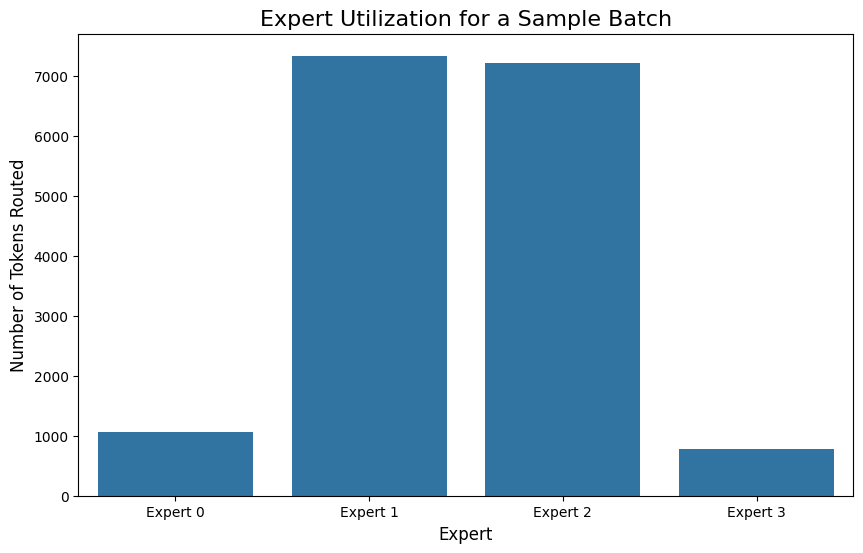


--- Calculating Routing Entropy for a Sample Batch ---


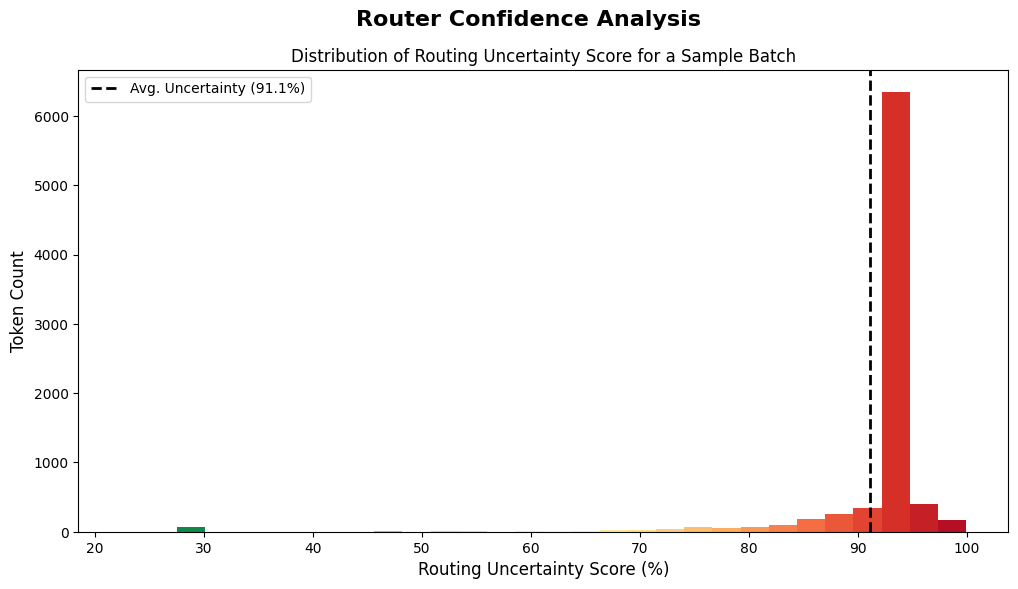


--- Qualitative Routing Analysis ---

MOST CONFIDENT Routing (Lowest Entropy):
  - Token: 'education'
  - Uncertainty Score: 22.4%
  - Expert Probabilities:
    - Expert 0: 3.6%
    - Expert 1: 1.1%
    - Expert 2: 93.3%
    - Expert 3: 1.9%

MOST UNCERTAIN Routing (Highest Entropy):
  - Token: '100'
  - Uncertainty Score: 99.9%
  - Expert Probabilities:
    - Expert 0: 24.8%
    - Expert 1: 23.4%
    - Expert 2: 25.0%
    - Expert 3: 26.8%

--- Starting Ablation Analysis ---
Calculating baseline accuracy...



Baseline Per-Class Accuracy (%):
               World  Sports  Business  Sci/Tech
Baseline Acc.    0.0   100.0       0.0       0.0

Ablating Expert 0...


Restored Expert 0.

Ablating Expert 1...


Restored Expert 1.

Ablating Expert 2...


Restored Expert 2.

Ablating Expert 3...


Restored Expert 3.

--- Ablation Analysis Results ---


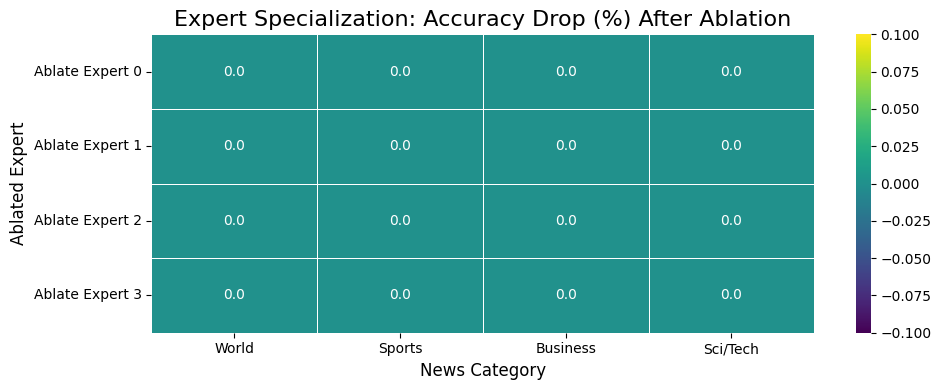

In [34]:
run_full_analysis(model, test_loader, DEVICE, NUM_CLASSES, NUM_EXPERTS, class_names)